In [2]:
import pandas as pd

/home/ian/jupyter/env3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/ian/jupyter/env3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [8]:
train = pd.read_csv("train_imperson_without4n7_balanced_data.csv")

Delete columns that have zero variance

In [9]:
col_to_delete = [k for k in train.columns if train[k].std()==0]

Of which there are

In [10]:
len(col_to_delete)

74

In [11]:
train = train.drop(col_to_delete,axis=1)
trainX = train[train.columns[:-1]]
trainY = train["155"]

In [18]:
trainX0 = trainX[trainY==0]
trainX1 = trainX[trainY>0]

In [22]:
len(trainX)

97044

# Feature selection

Build a data table to hold information regarding the remaining variables

(Some `pandas` operations are easier if the factor name is a regular column but it's nice for that to be the index too)

In [35]:
factors = pd.DataFrame(data = trainX.columns, columns = ['factor'], index = train.columns[:-1])

In [36]:
factors["mu0"] = factors.factor.apply(lambda f: trainX0[f].mean())
factors["mu1"] = factors.factor.apply(lambda f: trainX1[f].mean())

factors["sigma0"] = factors.factor.apply(lambda f: trainX0[f].std())
factors["sigma1"] = factors.factor.apply(lambda f: trainX1[f].std())

factors["rho"] = factors.factor.apply(lambda f: train[f].corr(train["155"]))

factors.head()

,factor,mu0,mu1,sigma0,sigma1,rho
5,5,0.005345,0.007160,0.018728,0.011431,0.058410
6,6,0.005345,0.007160,0.018728,0.011431,0.058410
8,8,0.349147,0.038526,0.450527,0.006735,-0.438183
9,9,0.349147,0.038526,0.450527,0.006735,-0.438183
14,14,0.999567,1.000000,0.020799,0.000000,0.014712


## correlation

Sorting factors by the absolute value of $\rho$, since a negative correlation is as predictive as a postive one

In [37]:
factors["absrho"]=abs(factors["rho"])

In [38]:
factors.sort_values(by="absrho", ascending=False).loc[factors["absrho"]>0.1]

,factor,mu0,mu1,sigma0,sigma1,rho,absrho
67,67,7.086695e-01,0.045289,0.260226,0.157740,-0.838937,0.838937
71,71,4.843164e-03,0.676456,0.069425,0.467833,0.708561,0.708561
50,50,4.031573e-01,0.999979,0.490537,0.004540,0.652165,0.652165
51,51,5.964099e-01,0.000021,0.490622,0.004540,-0.651828,0.651828
47,47,5.018176e-01,0.000022,0.450187,0.004542,-0.618997,0.618997
68,68,4.490540e-01,0.921829,0.470411,0.268404,0.525254,0.525254
38,38,6.591980e-01,0.768314,0.132439,0.024954,0.496848,0.496848
82,82,3.597495e-01,0.091727,0.329202,0.055956,-0.493602,0.493602
73,73,4.862330e-01,0.921870,0.499816,0.268378,0.477183,0.477183
146,146,5.687225e-02,0.000000,0.079131,0.000000,-0.453058,0.453058


## t-tests

t-tests establish the probability $p$ that we see a least that difference in the mean of a factor for the two conditions under the null hypothesis that they come from the same distribution

In [39]:
from scipy.stats import ttest_ind

In [40]:
factors["t-test p"] = factors.factor.apply(
    lambda f: ttest_ind(trainX0[f],
                        trainX1[f],
                        equal_var=False)[1]
)
factors.head()

,factor,mu0,mu1,sigma0,sigma1,rho,absrho,t-test p
5,5,0.005345,0.007160,0.018728,0.011431,0.058410,0.058410,4.460255e-74
6,6,0.005345,0.007160,0.018728,0.011431,0.058410,0.058410,4.460255e-74
8,8,0.349147,0.038526,0.450527,0.006735,-0.438183,0.438183,0.000000e+00
9,9,0.349147,0.038526,0.450527,0.006735,-0.438183,0.438183,0.000000e+00
14,14,0.999567,1.000000,0.020799,0.000000,0.014712,0.014712,4.583503e-06


Sort from lowest probability

In [41]:
factors.sort_values(by="t-test p")

,factor,mu0,mu1,sigma0,sigma1,rho,absrho,t-test p
154,154,0.334940,0.022008,0.458596,0.006407,-0.434536,0.434536,0.000000
94,94,0.055851,0.000289,0.229636,0.016984,-0.168196,0.168196,0.000000
77,77,0.038930,0.008852,0.095921,0.038162,-0.201783,0.201783,0.000000
75,75,0.005427,0.000290,0.011442,0.002490,-0.296245,0.296245,0.000000
73,73,0.486233,0.921870,0.499816,0.268378,0.477183,0.477183,0.000000
...,...,...,...,...,...,...,...,...
105,105,0.000021,0.000000,0.002780,0.000000,-0.005242,0.005242,0.102471
83,83,0.000041,0.000000,0.006420,0.000000,-0.004540,0.004540,0.157301
138,138,0.500008,0.500000,0.001725,0.000000,-0.003210,0.003210,0.317315
133,133,0.000021,0.000000,0.004540,0.000000,-0.003210,0.003210,0.317315


How many factors have $p<0.05$?

In [28]:
len(factors[factors["t-test p"] < 0.05])

70

$p<0.000000001$?

In [56]:
len(factors[factors["t-test p"] < 0.000000001])

51

So most of the factors have a significantly different mean under the two conditions

## unique values

Some factors appear to only have a few values, eg

In [57]:
len(train["133"].unique())

2

Add a column to track the number of unique values a factor takes

In [58]:
factors["vals"] = factors.factor.apply(lambda f: len(train[f].unique()))

In [64]:
factors.sort_values(by="vals").head(40)

,factor,mu0,mu1,sigma0,sigma1,rho,absrho,t-test p,vals
129,129,6.805573e-07,0.000000,0.000003,0.000000,-0.148360,0.148360,0.000000e+00,2
106,106,1.482495e-03,0.000018,0.035814,0.003934,-0.028733,0.028733,3.530465e-19,2
71,71,4.843164e-03,0.676456,0.069425,0.467833,0.708561,0.708561,0.000000e+00,2
72,72,1.978484e-03,0.000082,0.044437,0.009079,-0.029548,0.029548,3.419408e-20,2
73,73,4.862330e-01,0.921870,0.499816,0.268378,0.477183,0.477183,0.000000e+00,2
113,113,2.649747e-05,0.000000,0.003370,0.000000,-0.005560,0.005560,8.326452e-02,2
111,111,3.297473e-04,0.000577,0.018156,0.024015,0.005809,0.005809,7.037820e-02,2
133,133,2.060921e-05,0.000000,0.004540,0.000000,-0.003210,0.003210,3.173155e-01,2
83,83,4.121842e-05,0.000000,0.006420,0.000000,-0.004540,0.004540,1.573013e-01,2
84,84,1.236552e-04,0.000000,0.011119,0.000000,-0.007863,0.007863,1.430437e-02,2


There are a quite a few 2-value factors, it might be worth looking at what proportion of the values for a factor are non-zero overall, and under each class

In [78]:
l = len(trainX)
l0 = len(trainX0)
l1 = len(trainX1)
factors["nonzero"] = factors.factor.apply(lambda f: len(trainX.loc[trainX[f]!=0])/l)
factors["nonzero0"] = factors.factor.apply(lambda f: len(trainX0.loc[trainX0[f]!=0])/l0)
factors["nonzero1"] = factors.factor.apply(lambda f: len(trainX1.loc[trainX1[f]!=0])/l1)

In [82]:
factors.sort_values(by="nonzero").loc[factors["nonzero"]<0.001]

,factor,mu0,mu1,sigma0,sigma1,rho,absrho,t-test p,vals,nonzero,nonzero0,nonzero1
97,97,0.000021,0.000000,0.004540,0.000000,-0.003210,0.003210,3.173155e-01,2,0.000010,0.000021,0.000000
133,133,0.000021,0.000000,0.004540,0.000000,-0.003210,0.003210,3.173155e-01,2,0.000010,0.000021,0.000000
83,83,0.000041,0.000000,0.006420,0.000000,-0.004540,0.004540,1.573013e-01,2,0.000021,0.000041,0.000000
105,105,0.000021,0.000000,0.002780,0.000000,-0.005242,0.005242,1.024710e-01,3,0.000031,0.000062,0.000000
113,113,0.000026,0.000000,0.003370,0.000000,-0.005560,0.005560,8.326452e-02,2,0.000031,0.000062,0.000000
88,88,0.000029,0.000000,0.003466,0.000000,-0.005912,0.005912,6.551449e-02,4,0.000062,0.000124,0.000000
84,84,0.000124,0.000000,0.011119,0.000000,-0.007863,0.007863,1.430437e-02,2,0.000062,0.000124,0.000000
86,86,0.000165,0.000000,0.012839,0.000000,-0.009080,0.009080,4.676670e-03,2,0.000082,0.000165,0.000000
117,117,0.000013,0.000000,0.001288,0.000000,-0.007129,0.007129,2.637066e-02,6,0.000082,0.000165,0.000000
111,111,0.000330,0.000577,0.018156,0.024015,0.005809,0.005809,7.037820e-02,2,0.000453,0.000330,0.000577


These factors are extremely sparse, so may be noise.

In [57]:
from sklearn.linear_model import LogisticRegression

In [58]:
lr = LogisticRegression().fit(train[train.columns[:-1]],train["155"])

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [59]:
lr.score(train[train.columns[:-1]], train["155"])

0.9924879436132064

In [60]:
test = pd.read_csv("test_imperson_without4n7_balanced_data.csv")

In [61]:
test = test.drop(col_to_delete,axis=1)

In [62]:
lr.score(test[test.columns[:-1]], test["155"])

0.7348722545943523

So we have 73% accuracy from using all the non-constant columns in a default `sklearn` logistic regression, which includes some regularization.

Let's try only the 51 factors with extremely low t-test p-values

In [66]:
lowp = factors[factors["t-test p"] < 0.000000001].factor.values
lowp

array(['5', '6', '8', '9', '38', '47', '50', '51', '61', '64', '66', '67',
       '68', '70', '71', '72', '73', '75', '76', '77', '79', '80', '82',
       '90', '93', '94', '98', '104', '106', '107', '109', '110', '112',
       '118', '121', '122', '123', '125', '126', '127', '128', '129',
       '130', '140', '141', '142', '143', '144', '145', '146', '154'],
      dtype=object)

In [67]:
lr = LogisticRegression().fit(train[lowp],train["155"])

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [68]:
lr.score(test[lowp],test["155"])

0.5979630459684248

We can see if there is a threshold below which we get better accuracy

In [83]:
def p_threshold_to_lr_score(p):
    lowp = factors[factors["t-test p"] < p].factor.values
    lr = LogisticRegression(solver="liblinear").fit(train[lowp],train["155"])
    return lr.score(test[lowp],test["155"])
p_threshold_to_lr_score(0.01)

0.6113850291349171

In [70]:
import matplotlib.pyplot as plt

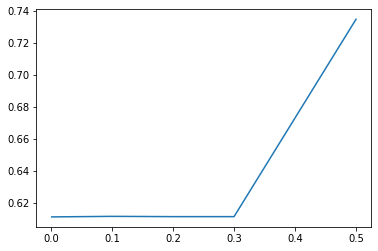

In [84]:
ps = [0.5, 0.3, 0.2, 0.1, 0.005, 0.001]
ss = [p_threshold_to_lr_score(p) for p in ps]
plt.plot(ps,ss)

Maybe some of the factors with higher p-values are actually better predictors..?

In [ ]:
lr = LogisticRegression().fit(train[train.columns[:-1]],train["155"])

In [87]:
lr.coef_

array([[-2.97188982e+00, -2.97188982e+00, -5.70423456e+00,
        -5.70423456e+00, -1.22188121e-01, -1.22188121e-01,
        -1.22188121e-01, -1.22188121e-01, -1.22188121e-01,
        -1.22188121e-01, -1.22188121e-01,  2.03462960e+00,
        -1.22188121e-01, -4.11851068e+00, -1.33828724e-01,
         1.03891618e+00, -1.16110430e+00, -1.22188121e-01,
         4.85871320e+00, -1.22188121e-01, -2.71606819e+00,
        -1.93423606e+00, -4.43167205e+00,  3.45810678e+00,
        -5.12423306e+00,  5.76116444e+00, -2.53150651e+00,
         4.16397375e+00,  6.05664910e-01,  7.85671962e-01,
         2.97773819e+00, -2.51923253e+00, -2.38570489e+00,
        -1.40349367e-01, -1.02270764e+01, -1.10047661e-04,
        -6.62944508e-04, -7.72992169e-04, -6.68604534e-05,
        -1.22188121e-01,  4.56870105e+00, -3.74304433e+00,
        -7.62789765e+00, -3.29112960e-05,  4.57385972e+00,
        -2.57598852e+00, -4.16488299e-04,  1.37102794e-01,
        -1.13304933e+01,  2.77876475e-02, -1.46395677e+0

Could look at size of coefficients as an indicator of importance..? Maybe something to pursue. Or could use random forest to get relative importances.

Looks like some factors are highly correlated, so perhaps PCA or clustering on factors first.

In [90]:
from sklearn.decomposition import PCA

In [92]:
pca = PCA(n_components=20)

In [93]:
pca.fit(train[train.columns[:-1]])

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [94]:
pca.explained_variance_

array([1.02098232, 0.86131361, 0.2540735 , 0.12245628, 0.1020006 ,
       0.06261603, 0.03867685, 0.03298436, 0.02661625, 0.02474394,
       0.02087587, 0.01080953, 0.0084663 , 0.00714234, 0.00627585,
       0.00611999, 0.00459349, 0.0039681 , 0.00341409, 0.00329887])

In [97]:
pca_train = pca.fit_transform(train[train.columns[:-1]])

In [98]:
lr = LogisticRegression().fit(pca_train,train["155"])

/home/ian/jupyter/env3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [99]:
pca_test = pca.transform(test[test.columns[:-1]])

In [100]:
lr.score(pca_test,test["155"])

0.8595049554260671

Twenty component PCA does relatively well.

Let's look at a few more or fewer components. We can do that by taking say fifty and then keeping the first 5, 10, 20, 50 of them

In [107]:
pca = PCA(n_components=50)

In [101]:
pca_train = pca.fit_transform(train[train.columns[:-1]])
pca_test = pca.transform(test[test.columns[:-1]])

In [104]:
for pcs in [1,5,10,20,50]:
    lr = LogisticRegression(solver='liblinear').fit(pca_train[:,:pcs],train["155"])
    score = lr.score(pca_test[:,:pcs], test["155"])
    print(f"{pcs}:\t{score}")

1:	0.8479007918721052
5:	0.9719358533791523
10:	0.9775885253249664
20:	0.8595049554260671
50:	0.8595049554260671


Looking closer at 1 to 20:

In [108]:
def principalcomponents_lrscore(n):
    lr = LogisticRegression(solver='liblinear').fit(pca_train[:,:n],train["155"])
    score = lr.score(pca_test[:,:n], test["155"])
    return score

In [ ]:
pcs = list(range(1,20))
lrs = [principalcomponents_lrscore(n) for n in pcs]

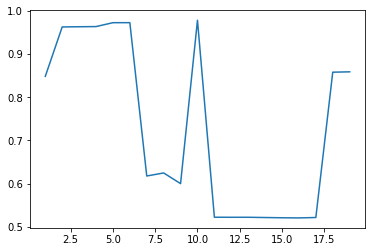

In [109]:
plt.plot(pcs, lrs)

Seems 10 is a good choice of principal components

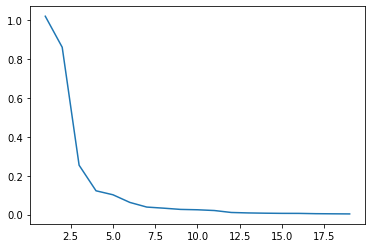

In [113]:
pca = PCA(n_components=19)
pca.fit(train[train.columns[:-1]])
plt.plot(pcs,pca.explained_variance_)

Cross-validation in logistic regression

In [1]:
from sklearn.linear_model import LogisticRegressionCV